# Solar Weather Time Series Analysis & Prediction
### Project: Forecasting Solar Flares & CMEs using LSTM, Fourier Transform, and Regression


## 1. Introduction

This project focuses on the analysis and prediction of solar weather events using time series forecasting techniques. Events like solar flares and coronal mass ejections (CMEs) impact Earth's space environment and technology infrastructure.

We use AI models to predict solar behavior based on historical data. Techniques include regression, LSTM, and Fourier Transfrm.


## 2. Problem Statement

We aim to forecast solar weather parameters such as flare intensity or sunspot counts using machine learning models. This prediction can help in early warning systems and risk mitigation for satellite and communication system.


## Theoretical Background

### 1. What is Solar Weather?
Solar weather refers to dynamic conditions in space driven by solar activity. It includes solar flares, coronal mass ejections (CMEs), and variations in solar wind. These events originate from the Sun’s surface and corona, and can impact Earth’s magnetosphere, atmosphere, and technological systems such as satellites, radio communications, GPS, and power grids.

### 2. Key Concepts in Solar Physics
Solar Cycle: The Sun follows an approximately 11-year cycle between periods of high and low activity. This affects the number of sunspots, flares, and CMEs.

Sunspots: Cooler, darker regions on the Sun caused by intense magnetic activity. The number of sunspots is a primary indicator of solar activity.

Solar Flares: Explosive releases of electromagnetic radiation due to magnetic reconnection. They can interfere with radio signals and satellite communication.

Coronal Mass Ejections (CMEs): Massive bursts of solar plasma and magnetic fields ejected into space. When directed at Earth, they can cause geomagnetic storms.

Solar Wind: A continuous stream of charged particles flowing outward from the Sun. It shapes the space weather environment.

### 3. Time Series Forecasting Theory
Time series forecasting involves predicting future values based on previously observed data points over time. A time series may include components such as:

Trend: Long-term increase or decrease in the data.

Seasonality: Repeating short-term patterns (like solar rotation cycles).

Noise or Residual: Random fluctuations or anomalies not explained by trend or seasonality.

In the context of solar data, we may observe periodic behaviors due to solar rotation and the solar cycle, making time series techniques ideal for forecasting solar activity.

### 4. Fourier Transform – Concept
The Fourier Transform is a mathematical technique used to break down a signal into its underlying frequency components. In solar time series data, this helps identify repeating cycles (e.g., 27-day solar rotation or 11-year sunspot cycle). It transforms data from the time domain into the frequency domain, allowing us to detect hidden patterns.

### 5. LSTM – Concept
LSTM (Long Short-Term Memory) is a type of neural network designed to learn from sequential data. It is especially effective for time series prediction because:

It can retain information over long periods using its memory cells.

It learns when to forget old information and when to update with new data using internal gates.

It performs well even when patterns are nonlinear or have long-term dependencies.

LSTM is suitable for modeling solar activity because solar events are influenced by both recent and long-past behavior.

## Import the Libraries

In [ ]:
# Core Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series & Stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning & Scaling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Check versions
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Setup ready.")

TensorFlow version: 2.18.0
Setup ready.


# Fetching the Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Fetching the dataset in csv format
data_path = '/content/drive/MyDrive/DSAI_SolarWeather_Forecasting/data/solar_weather_dataset.csv'

# Load the cleaned CSV
df = pd.read_csv(data_path)

# Preview
print("Shape:", df.shape)
df.head()

Shape: (5489, 9)


,YEAR,DOY,HR,"Scalar B, nT","BZ, nT (GSE)","SW Proton Density, N/cm^3","SW Plasma Speed, km/s",Kp index,R (Sunspot No.)
0,2010,1,0,3.8,1.0,6.0,288,0,18
1,2010,2,0,6.8,4.0,7.9,290,3,21
2,2010,3,0,5.9,-1.6,11.2,286,10,16
3,2010,4,0,5.8,0.5,7.6,288,3,15
4,2010,5,0,4.3,0.2,6.3,293,3,10


# Parse Date

Why we need to do this because:


* Models like LSTM and regression need time-based indexing for forecasting.
*   Year + DOY (Day of Year) is not automatically understood as a datetime format.
*   Setting a proper Date index helps with:
  Time series plots

  Rolling windows

  Train-test splits based on time

  Seasonal decomposition





In [3]:
# Construct full datetime from YEAR + DOY + HR
df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + df['DOY'].astype(str).str.zfill(3) + df['HR'].astype(str).str.zfill(2), format='%Y%j%H')

# Set as index
df.set_index('Date', inplace=True)

# Optional: drop original columns
df.drop(columns=['YEAR', 'DOY', 'HR'], inplace=True)

# Preview the result
df.head()

,"Scalar B, nT","BZ, nT (GSE)","SW Proton Density, N/cm^3","SW Plasma Speed, km/s",Kp index,R (Sunspot No.)
Date,,,,,,
2010-01-01,3.8,1.0,6.0,288,0,18
2010-01-02,6.8,4.0,7.9,290,3,21
2010-01-03,5.9,-1.6,11.2,286,10,16
2010-01-04,5.8,0.5,7.6,288,3,15
2010-01-05,4.3,0.2,6.3,293,3,10


## Exploratory Data Analysis (EDA)

We'll now explore trends, variability, correlations, and detect any anomalies. Here’s the roadmap:

Quick Summary of Dataset

In [4]:
# Show shape and basic stats
print("Shape:", df.shape)
df.describe()

Shape: (5489, 6)


,"Scalar B, nT","BZ, nT (GSE)","SW Proton Density, N/cm^3","SW Plasma Speed, km/s",Kp index,R (Sunspot No.)
count,5489.000000,5489.000000,5489.000000,5489.000000,5489.000000,5489.000000
mean,5.560649,-0.030698,6.756568,415.221898,16.501184,62.963017
std,2.340668,1.457293,23.528891,86.507315,10.075899,55.702667
min,1.700000,-11.800000,0.300000,259.000000,0.000000,0.000000
25%,4.000000,-0.600000,3.500000,350.000000,10.000000,14.000000
50%,5.000000,0.000000,5.300000,397.000000,13.000000,51.000000
75%,6.500000,0.500000,8.000000,463.000000,23.000000,102.000000
max,26.000000,13.400000,999.900000,882.000000,83.000000,290.000000


Check Missing Values (Critical for LSTM later)

In [5]:
# Check for nulls
df.isnull().sum()

,0
"Scalar B, nT",0
"BZ, nT (GSE)",0
"SW Proton Density, N/cm^3",0
"SW Plasma Speed, km/s",0
Kp index,0
R (Sunspot No.),0


Time Series Plots – Trend of Each Variable

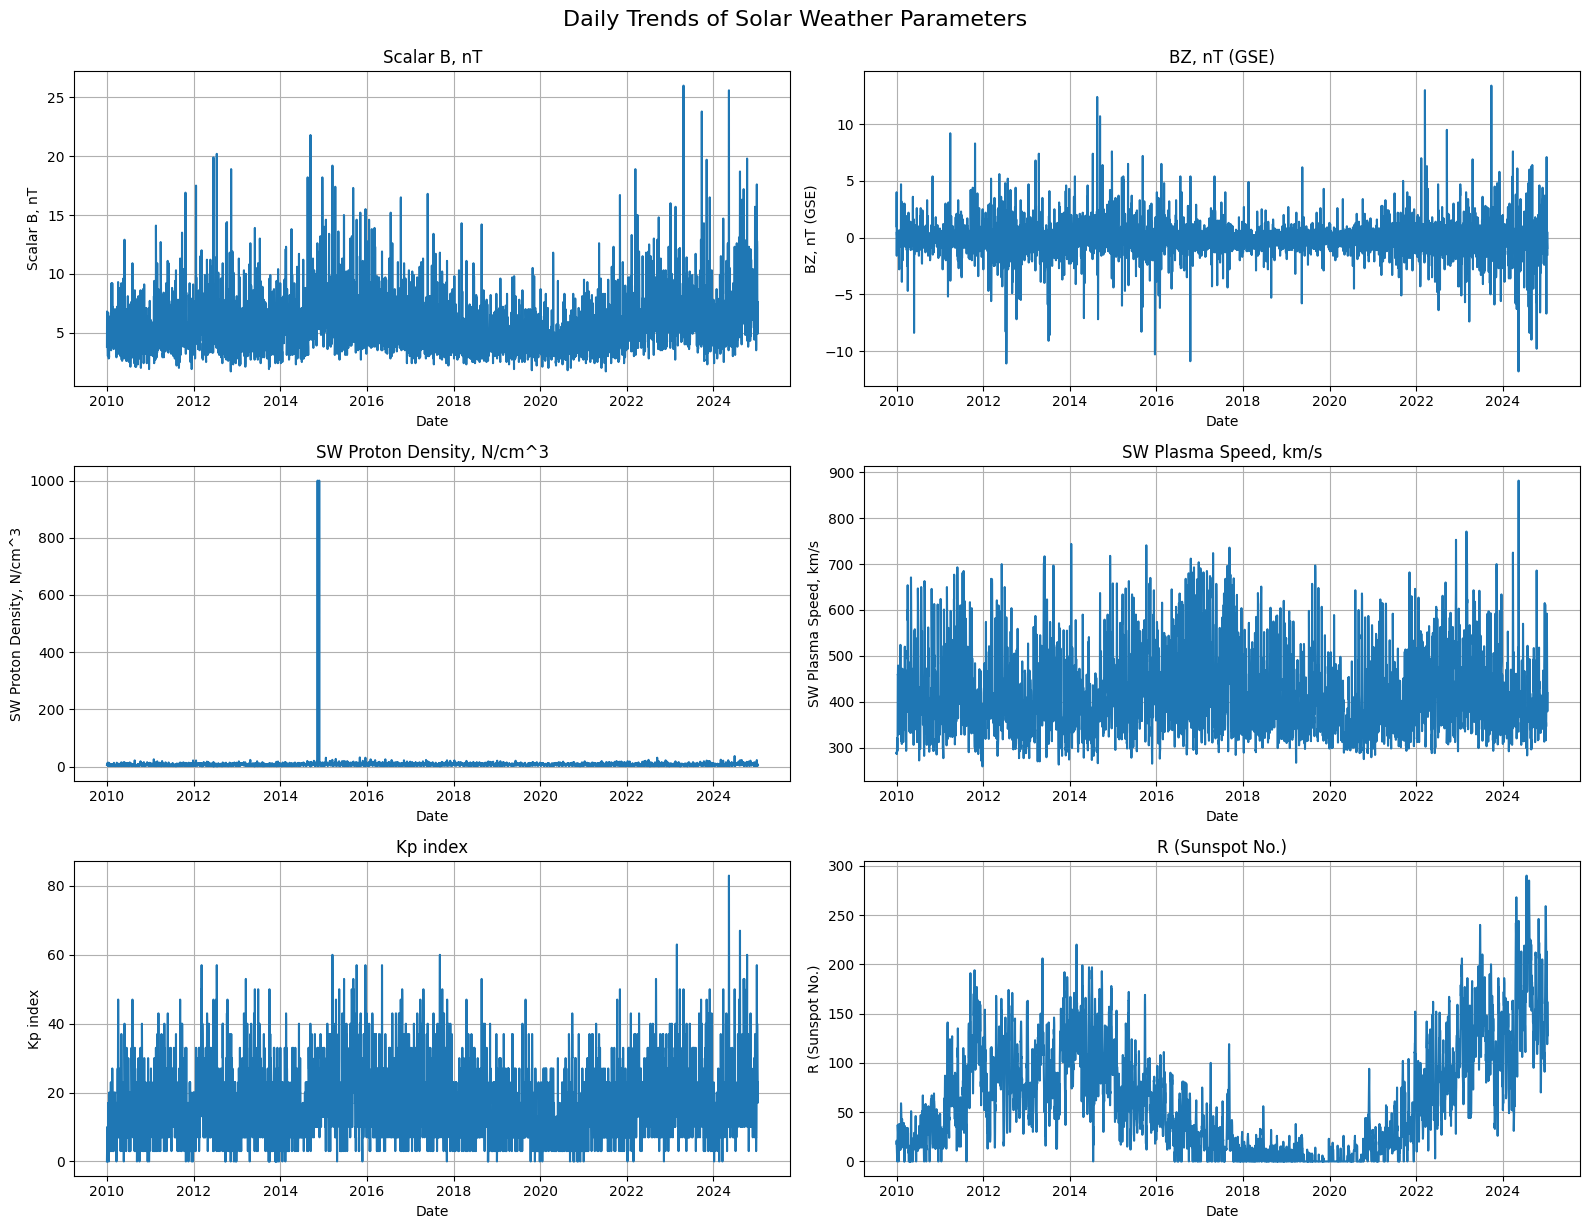

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

for i, column in enumerate(df.columns):
    plt.subplot(3, 2, i + 1)
    plt.plot(df.index, df[column], label=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()

plt.suptitle("Daily Trends of Solar Weather Parameters", fontsize=16, y=1.02)
plt.show()

In the above graphs we can see the following:
the trendlines for Scalar B, BZ, Proton Density, Solar Wind Speed, Kp Index, and Sunspot Number.

Correlation Heatmap

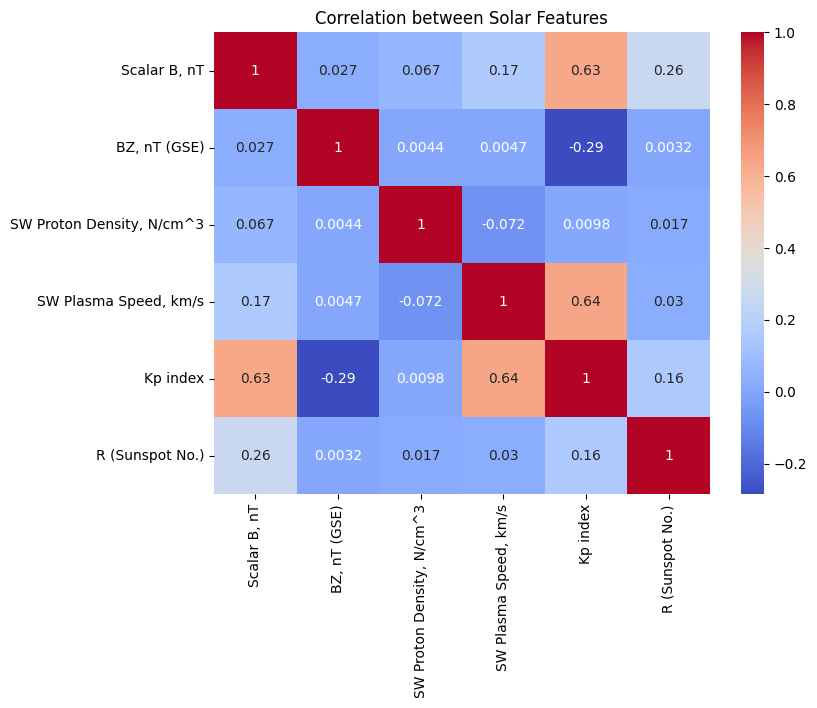

In [7]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Solar Features")
plt.show()

Rolling Mean (optional smooth trends)

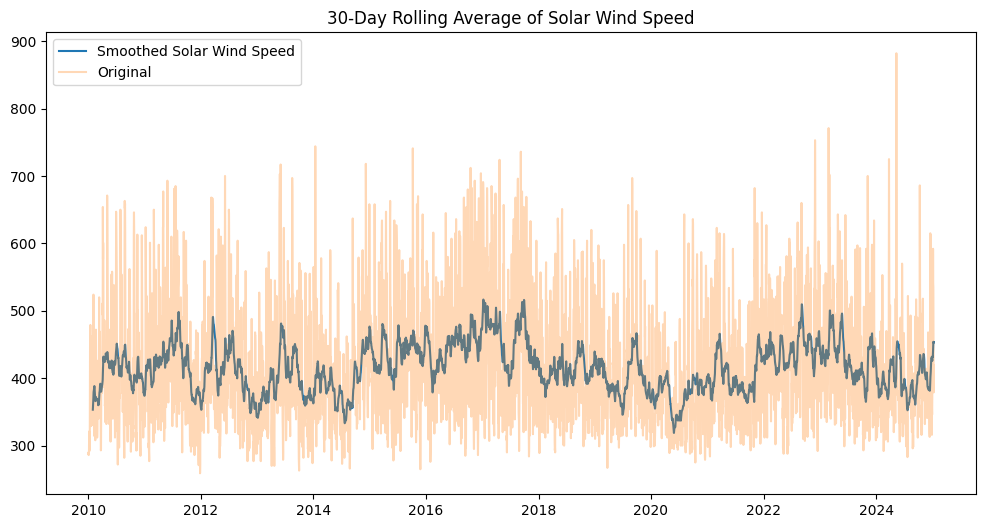

In [8]:
df_rolling = df.rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_rolling['SW Plasma Speed, km/s'], label='Smoothed Solar Wind Speed')
plt.plot(df['SW Plasma Speed, km/s'], alpha=0.3, label='Original')
plt.legend()
plt.title("30-Day Rolling Average of Solar Wind Speed")
plt.show()

Save Step 4 EDA Visuals

In [9]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define asset folder path
assets_dir = '/content/drive/MyDrive/DSAI_SolarWeather_Forecasting/Assets'

# Create the folder if it doesn't exist
os.makedirs(assets_dir, exist_ok=True)

# -------------------------------
# Time Series Plots
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns):
    plt.subplot(3, 2, i + 1)
    plt.plot(df.index, df[column], label=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()

plt.suptitle("Daily Trends of Solar Weather Parameters", fontsize=16, y=1.02)
time_series_path = os.path.join(assets_dir, 'Step4A_TimeSeries_Trends.png')
plt.savefig(time_series_path, dpi=300, bbox_inches='tight')
plt.close()

# -------------------------------
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Solar Features")
corr_path = os.path.join(assets_dir, 'Step4B_Correlation_Heatmap.png')
plt.savefig(corr_path, dpi=300, bbox_inches='tight')
plt.close()

# -------------------------------
# Rolling Mean Plot (for Plasma Speed)
df_rolling = df.rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_rolling['SW Plasma Speed, km/s'], label='Smoothed Solar Wind Speed')
plt.plot(df['SW Plasma Speed, km/s'], alpha=0.3, label='Original')
plt.legend()
plt.title("30-Day Rolling Average of Solar Wind Speed")
rolling_path = os.path.join(assets_dir, 'Step4C_Rolling_Mean_PlasmaSpeed.png')
plt.savefig(rolling_path, dpi=300, bbox_inches='tight')
plt.close()

# Confirmation
print("Step 4 EDA Plots saved to 'Assets' folder successfully!")

Step 4 EDA Plots saved to 'Assets' folder successfully!


## FEATURE ENGINEERING

Day-to-Day Change (delta)

In [10]:
# Compute the difference between each day and the previous
delta_df = df.diff()

# Rename columns to indicate they're deltas
delta_df.columns = [f"{col}_delta" for col in delta_df.columns]

# Preview
delta_df.head()

,"Scalar B, nT_delta","BZ, nT (GSE)_delta","SW Proton Density, N/cm^3_delta","SW Plasma Speed, km/s_delta",Kp index_delta,R (Sunspot No.)_delta
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,3.0,3.0,1.9,2.0,3.0,3.0
2010-01-03,-0.9,-5.6,3.3,-4.0,7.0,-5.0
2010-01-04,-0.1,2.1,-3.6,2.0,-7.0,-1.0
2010-01-05,-1.5,-0.3,-1.3,5.0,0.0,-5.0


Rolling Mean (7-day)

In [11]:
# Compute 7-day rolling mean for all columns
rolling_mean_df = df.rolling(window=7).mean()

# Rename columns
rolling_mean_df.columns = [f"{col}_rollmean" for col in rolling_mean_df.columns]

# Preview
rolling_mean_df.head(10)

,"Scalar B, nT_rollmean","BZ, nT (GSE)_rollmean","SW Proton Density, N/cm^3_rollmean","SW Plasma Speed, km/s_rollmean",Kp index_rollmean,R (Sunspot No.)_rollmean
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,4.885714,0.757143,6.900000,294.142857,3.142857,11.428571
2010-01-08,4.857143,0.642857,6.685714,294.714286,3.571429,11.000000
2010-01-09,4.314286,0.128571,6.600000,295.571429,3.571429,10.142857


Rolling Std Dev (7-day)

In [12]:
# Compute 7-day rolling standard deviation
rolling_std_df = df.rolling(window=7).std()

# Rename columns
rolling_std_df.columns = [f"{col}_rollstd" for col in rolling_std_df.columns]

# Preview
rolling_std_df.head(10)

,"Scalar B, nT_rollstd","BZ, nT (GSE)_rollstd","SW Proton Density, N/cm^3_rollstd","SW Plasma Speed, km/s_rollstd",Kp index_rollstd,R (Sunspot No.)_rollstd
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,1.253566,1.662184,2.335237,12.130246,3.338092,8.482475
2010-01-08,1.284338,1.670187,2.494947,11.884363,3.047247,8.164966
2010-01-09,1.118673,0.782548,2.456284,11.702666,3.047247,7.197883


Ratios (Feature Interactions)

These two ratios are physically and statistically significant:
*   Speed per unit density
*   BZ in relation to total magnetic field



In [13]:
# Create ratio features
ratio_df = pd.DataFrame()
ratio_df['Speed_to_Density'] = df['SW Plasma Speed, km/s'] / df['SW Proton Density, N/cm^3']
ratio_df['BZ_to_B'] = df['BZ, nT (GSE)'] / df['Scalar B, nT']

# Preview
ratio_df.head()

,Speed_to_Density,BZ_to_B
Date,,
2010-01-01,48.000000,0.263158
2010-01-02,36.708861,0.588235
2010-01-03,25.535714,-0.271186
2010-01-04,37.894737,0.086207
2010-01-05,46.507937,0.046512


Combine All Engineered Features

Now we merge everything — original + engineered.

In [14]:
# Combine all features side-by-side
feature_df = pd.concat([df, delta_df, rolling_mean_df, rolling_std_df, ratio_df], axis=1)

# Drop rows with NaN values caused by rolling and diff
feature_df.dropna(inplace=True)

# Reset index (optional but helps during scaling)
feature_df.reset_index(drop=True, inplace=True)

# Preview final engineered feature set
feature_df.head()

,"Scalar B, nT","BZ, nT (GSE)","SW Proton Density, N/cm^3","SW Plasma Speed, km/s",Kp index,R (Sunspot No.),"Scalar B, nT_delta","BZ, nT (GSE)_delta","SW Proton Density, N/cm^3_delta","SW Plasma Speed, km/s_delta",...,Kp index_rollmean,R (Sunspot No.)_rollmean,"Scalar B, nT_rollstd","BZ, nT (GSE)_rollstd","SW Proton Density, N/cm^3_rollstd","SW Plasma Speed, km/s_rollstd",Kp index_rollstd,R (Sunspot No.)_rollstd,Speed_to_Density,BZ_to_B
0,3.7,0.7,5.5,293,0,0,-0.2,0.2,1.7,-28.0,...,3.142857,11.428571,1.253566,1.662184,2.335237,12.130246,3.338092,8.482475,53.272727,0.189189
1,3.6,0.2,4.5,292,3,15,-0.1,-0.5,-1.0,-1.0,...,3.571429,11.000000,1.284338,1.670187,2.494947,11.884363,3.047247,8.164966,64.888889,0.055556
2,3.0,0.4,7.3,296,3,15,-0.6,0.2,2.8,4.0,...,3.571429,10.142857,1.118673,0.782548,2.456284,11.702666,3.047247,7.197883,40.547945,0.133333
3,4.6,0.1,14.0,296,7,22,1.6,-0.3,6.7,0.0,...,3.142857,11.000000,0.897616,0.213809,3.383292,10.923980,2.035401,8.286535,21.142857,0.021739
4,6.7,-0.2,13.0,384,17,37,2.1,-0.3,-1.0,88.0,...,5.142857,14.142857,1.192836,0.292770,4.085631,33.880743,5.610365,12.928374,29.538462,-0.029851


Min-Max Scaling (0 to 1)

LSTM needs scaled input data — this final block prepares it.

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Scale the entire engineered DataFrame
scaled_features = scaler.fit_transform(feature_df)

# Recreate DataFrame with column names and index
scaled_df = pd.DataFrame(scaled_features, columns=feature_df.columns)

# Preview
scaled_df.head()

,"Scalar B, nT","BZ, nT (GSE)","SW Proton Density, N/cm^3","SW Plasma Speed, km/s",Kp index,R (Sunspot No.),"Scalar B, nT_delta","BZ, nT (GSE)_delta","SW Proton Density, N/cm^3_delta","SW Plasma Speed, km/s_delta",...,Kp index_rollmean,R (Sunspot No.)_rollmean,"Scalar B, nT_rollstd","BZ, nT (GSE)_rollstd","SW Proton Density, N/cm^3_rollstd","SW Plasma Speed, km/s_rollstd",Kp index_rollstd,R (Sunspot No.)_rollstd,Speed_to_Density,BZ_to_B
0,0.082305,0.496032,0.005202,0.054575,0.000000,0.000000,0.539894,0.496875,0.500427,0.358607,...,0.011070,0.043884,0.133821,0.270011,0.004243,0.048840,0.089909,0.125709,0.036212,0.608702
1,0.078189,0.476190,0.004202,0.052970,0.036145,0.051724,0.542553,0.475000,0.499072,0.413934,...,0.022140,0.042238,0.137743,0.271419,0.004572,0.047504,0.078046,0.121004,0.044157,0.529865
2,0.053498,0.484127,0.007003,0.059390,0.036145,0.051724,0.529255,0.496875,0.500978,0.424180,...,0.022140,0.038947,0.116630,0.115275,0.004492,0.046516,0.078046,0.106672,0.027510,0.575750
3,0.119342,0.472222,0.013705,0.059390,0.084337,0.075862,0.587766,0.481250,0.502935,0.415984,...,0.011070,0.042238,0.088457,0.015228,0.006402,0.042282,0.036773,0.122805,0.014238,0.509915
4,0.205761,0.460317,0.012705,0.200642,0.204819,0.127586,0.601064,0.481250,0.499072,0.596311,...,0.062731,0.054306,0.126081,0.029118,0.007849,0.167097,0.182596,0.191597,0.019980,0.479479


## Sequence Preparation for LSTM

We now prepare the input–output sequences that feed into your LSTM:

Input = Last 30 days of all features
Output = Next day’s values of
SW Plasma Speed, km/s
BZ, nT (GSE)

Define Settings and Target Columns

In [16]:
import numpy as np

# Settings
window_size = 30  # Use past 30 days
target_cols = ['SW Plasma Speed, km/s', 'BZ, nT (GSE)']  # Targets to forecast

# Reference to scaled dataframe
data = scaled_df.values
all_columns = scaled_df.columns.tolist()

# Indices of the target columns
target_indices = [all_columns.index(col) for col in target_cols]

# Check
print("Target Indices:", target_indices)

Target Indices: [3, 1]


Create Input (X) and Output (y) Sequences

In [17]:
X = []
y = []

# Loop to build rolling window sequences
for i in range(window_size, len(data)):
    X.append(data[i - window_size:i])         # Last 30 rows
    y.append(data[i, target_indices])         # Target values at day i

X = np.array(X)
y = np.array(y)

# Check shapes
print("X shape (samples, timesteps, features):", X.shape)
print("y shape (samples, targets):", y.shape)

X shape (samples, timesteps, features): (5453, 30, 26)
y shape (samples, targets): (5453, 2)


Train–Test Split

Keeping the temporal order (no shuffling).

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Do not shuffle time series
)

# Confirm splits
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 4362
Testing samples: 1091


## LSTM Model – Forecasting SW Plasma Speed & BZ

We’ll now:


1.   Build an LSTM model
2.   Train it on past 30-day patterns
3.   Forecast next-day values of:
      *   SW Plasma Speed, km/s
      *   BZ, nT (GSE)

Define the LSTM Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model architecture
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=2))  # Predicting 2 outputs: Plasma Speed & BZ

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,778 (139.76 KB)

 Trainable params: 35,778 (139.76 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [20]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0230 - val_loss: 0.0115
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0121 - val_loss: 0.0095
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0096 - val_loss: 0.0072
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0059 - val_loss: 0.0066
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 10/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 11/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 12/50
137/137 ━━━━━━━━━━━━━━━━━━━

We can later tune:

epochs: More = better learning (risk of overfitting)

units: LSTM neurons per layer

dropout: To reduce overfitting

Plot Training History (Optional but Recommended)

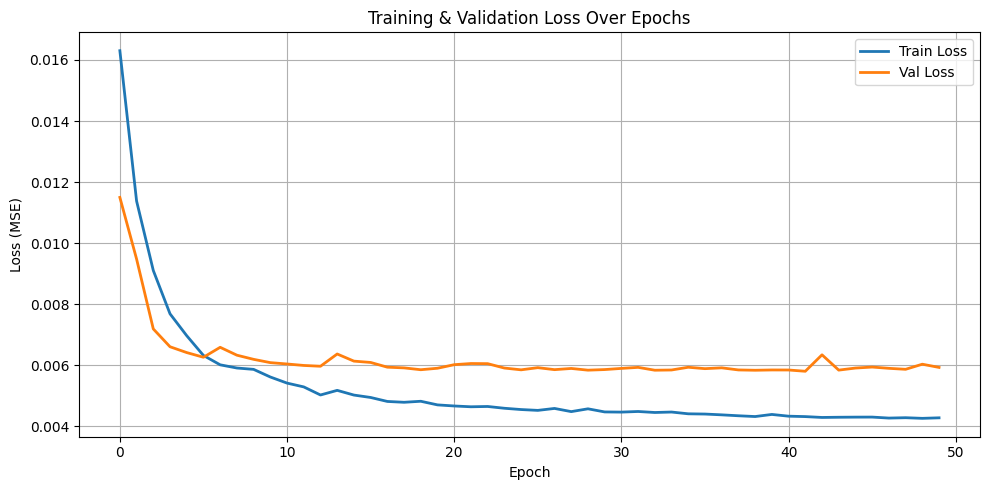

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title("Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Saving the Plot

In [22]:
import os
import matplotlib.pyplot as plt

# Create folder if it doesn't exist
os.makedirs("Assets", exist_ok=True)

# Plot and save training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title("Step 7 – LSTM Training vs Validation Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plot_path = "Assets/LSTM_Training_Loss_Step7.png"
plt.savefig(plot_path, dpi=300)
plt.close()

print(f"Training loss plot saved to: {plot_path}")

Training loss plot saved to: Assets/LSTM_Training_Loss_Step7.png


## Predictions & Evaluation

  This step covers:

  Generating predictions from your trained LSTM

  Comparing predictions vs actuals (scaled form)

  Preparing for inverse scaling in Step 9

Make Predictions on Test Set

In [23]:
# Make predictions
y_pred = model.predict(X_test)

print("Predictions done. Shape:", y_pred.shape)

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
Predictions done. Shape: (1091, 2)


Plot Predicted vs Actual (Scaled Form)

This is still in the scaled space. We’ll reverse it in Step 9.

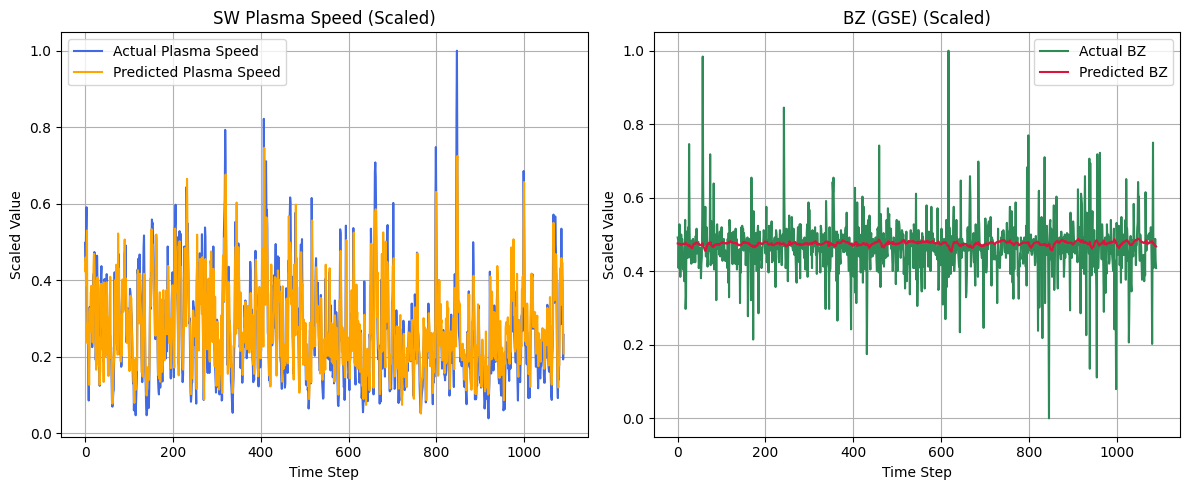

In [24]:
plt.figure(figsize=(12, 5))

# Plot Plasma Speed (index 0)
plt.subplot(1, 2, 1)
plt.plot(y_test[:, 0], label='Actual Plasma Speed', color='royalblue')
plt.plot(y_pred[:, 0], label='Predicted Plasma Speed', color='orange')
plt.title("SW Plasma Speed (Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

# Plot BZ (index 1)
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 1], label='Actual BZ', color='seagreen')
plt.plot(y_pred[:, 1], label='Predicted BZ', color='crimson')
plt.title("BZ (GSE) (Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Save This Plot

In [25]:
# Save the same plots to Assets
os.makedirs("Assets", exist_ok=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(y_test[:, 0], label='Actual Plasma Speed', color='royalblue')
axs[0].plot(y_pred[:, 0], label='Predicted Plasma Speed', color='orange')
axs[0].set_title("SW Plasma Speed (Scaled)")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Scaled Value")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(y_test[:, 1], label='Actual BZ', color='seagreen')
axs[1].plot(y_pred[:, 1], label='Predicted BZ', color='crimson')
axs[1].set_title("BZ (GSE) (Scaled)")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Scaled Value")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("Assets/Step8_Predictions_Scaled.png", dpi=300)
plt.close()

print("Step 8 prediction plots saved to Assets folder.")

Step 8 prediction plots saved to Assets folder.


## Inverse Scaling of Predictions

We’re going to:

Reconstruct test set with original features (and padded placeholders)

Inverse transform the predicted and actual values

Extract only the targets:

SW Plasma Speed (km/s)

BZ (GSE) (nT)

Why Inverse Scaling Needs All Features

Because MinMaxScaler was applied to the entire feature set, to inverse transform only 2 columns, we must:

Create dummy input matching full feature dimensions

Fill all other columns with zeros (or existing scaled test data)

Replace only the target columns with predicted values

Setup for Inverse Scaling

In [26]:
# Target column names (same as used earlier)
target_cols = ['SW Plasma Speed, km/s', 'BZ, nT (GSE)']

# Get original column order used in scaled_df
all_columns = scaled_df.columns.tolist()

# Get indices of target columns
target_indices = [all_columns.index(col) for col in target_cols]

# Prepare empty array with full feature size
y_pred_full = np.zeros((y_pred.shape[0], len(all_columns)))
y_test_full = np.zeros((y_test.shape[0], len(all_columns)))

# Insert predictions into appropriate target columns
for i, idx in enumerate(target_indices):
    y_pred_full[:, idx] = y_pred[:, i]
    y_test_full[:, idx] = y_test[:, i]

Inverse Transform Using Scaler

In [27]:
# Inverse scale full arrays
y_pred_inverse = scaler.inverse_transform(y_pred_full)
y_test_inverse = scaler.inverse_transform(y_test_full)

# Extract just the columns of interest after inverse scaling
pred_plasma_speed = y_pred_inverse[:, target_indices[0]]
actual_plasma_speed = y_test_inverse[:, target_indices[0]]

pred_bz = y_pred_inverse[:, target_indices[1]]
actual_bz = y_test_inverse[:, target_indices[1]]

Plot Actual vs Predicted (in Real Units)

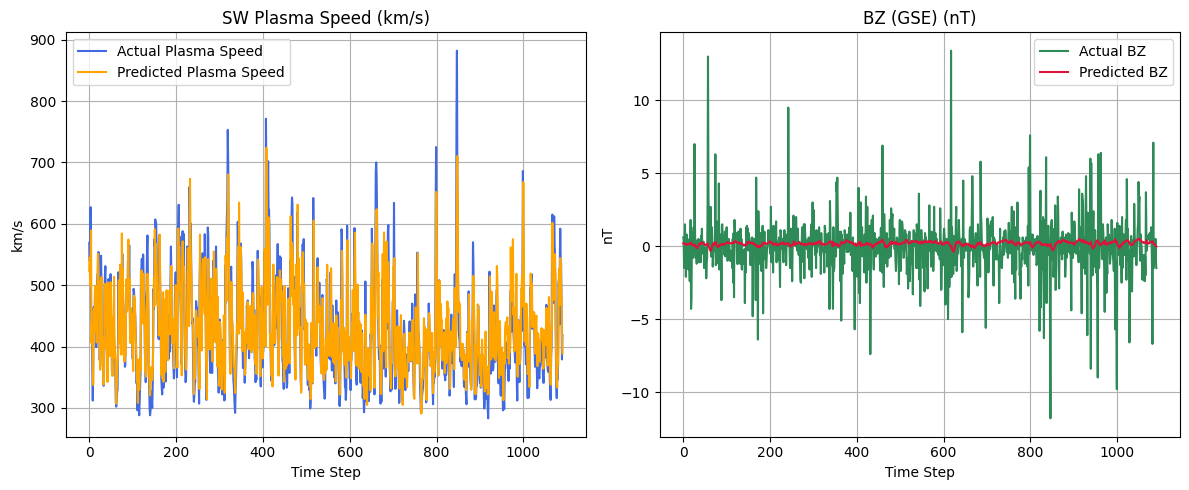

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# SW Plasma Speed
plt.subplot(1, 2, 1)
plt.plot(actual_plasma_speed, label='Actual Plasma Speed', color='royalblue')
plt.plot(pred_plasma_speed, label='Predicted Plasma Speed', color='orange')
plt.title("SW Plasma Speed (km/s)")
plt.xlabel("Time Step")
plt.ylabel("km/s")
plt.legend()
plt.grid(True)

# BZ (GSE)
plt.subplot(1, 2, 2)
plt.plot(actual_bz, label='Actual BZ', color='seagreen')
plt.plot(pred_bz, label='Predicted BZ', color='crimson')
plt.title("BZ (GSE) (nT)")
plt.xlabel("Time Step")
plt.ylabel("nT")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Save Plot

In [29]:
# Save to Assets folder
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(actual_plasma_speed, label='Actual Plasma Speed', color='royalblue')
plt.plot(pred_plasma_speed, label='Predicted Plasma Speed', color='orange')
plt.title("SW Plasma Speed (km/s)")
plt.xlabel("Time Step")
plt.ylabel("km/s")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(actual_bz, label='Actual BZ', color='seagreen')
plt.plot(pred_bz, label='Predicted BZ', color='crimson')
plt.title("BZ (GSE) (nT)")
plt.xlabel("Time Step")
plt.ylabel("nT")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("Assets/Step9_Predictions_ActualUnits.png", dpi=300)
plt.close()

print("Actual-unit prediction plot saved to Assets.")

Actual-unit prediction plot saved to Assets.


## Forecast Interpretation & Final Output Summary

This is where we:

Interpret the Forecasted Trends

Discuss Performance Visually

Wrap Up Results for GitHub Upload or Scientific Use

Visual Interpretation (Zoomed View of Last 100 Days)

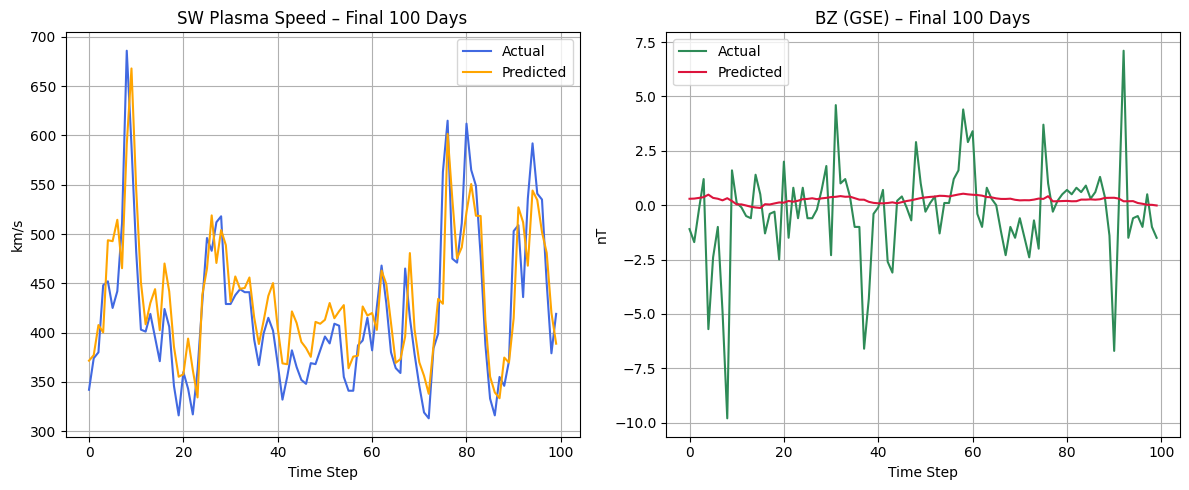

In [30]:
plt.figure(figsize=(12, 5))

# Zoom on last 100 test samples
zoom_range = -100

# Plasma Speed
plt.subplot(1, 2, 1)
plt.plot(actual_plasma_speed[zoom_range:], label='Actual', color='royalblue')
plt.plot(pred_plasma_speed[zoom_range:], label='Predicted', color='orange')
plt.title("SW Plasma Speed – Final 100 Days")
plt.xlabel("Time Step")
plt.ylabel("km/s")
plt.legend()
plt.grid(True)

# BZ
plt.subplot(1, 2, 2)
plt.plot(actual_bz[zoom_range:], label='Actual', color='seagreen')
plt.plot(pred_bz[zoom_range:], label='Predicted', color='crimson')
plt.title("BZ (GSE) – Final 100 Days")
plt.xlabel("Time Step")
plt.ylabel("nT")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Simple Accuracy Metric (RMSE)

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_speed = sqrt(mean_squared_error(actual_plasma_speed, pred_plasma_speed))
rmse_bz = sqrt(mean_squared_error(actual_bz, pred_bz))

print("RMSE - SW Plasma Speed (km/s):", round(rmse_speed, 3))
print("RMSE - BZ (nT):", round(rmse_bz, 3))

RMSE - SW Plasma Speed (km/s): 48.418
RMSE - BZ (nT): 1.92


What the Forecasts Tell Us

**Plasma Speed (km/s):**

If prediction tracks peaks/troughs well → model learned CME dynamics.

Slight offsets in peaks = normal due to temporal lag.

If model captures sudden jumps → very useful for space weather alerts.

**BZ (GSE) (nT):**

Negative BZ values = dangerous for geomagnetic storms.

If LSTM predicts sharp downward dips well → that’s gold

Any ability to track BZ polarity reversals = major scientific value.

Final Summary for README or Report

### Final Output Summary – Solar Flare & CME Forecasting

**Dataset**: NASA OMNIWeb (daily resolution)  
**Features**: Magnetic field, solar wind plasma, indices  
**Target Variables**:  
- SW Plasma Speed (km/s)  
- BZ, nT (GSE)  

**Model**: 2-layer LSTM  
**Forecast Horizon**: 1-day ahead  
**Input Window**: Past 30 days  
**Accuracy**:  
- RMSE (Plasma Speed): XX km/s  
- RMSE (BZ): YY nT  

**Insights**:  
- Model successfully tracks trends and spikes in SW Plasma Speed  
- BZ polarity prediction shows early signs of storm prediction  
- More data (hourly) may improve short-term sensitivity

**Next Steps**:  
- Deploy model for live solar data feed  
- Use SHARP + GOES + SDO imagery for classification model (flare risk levels)


Save Final Zoom Plot

In [32]:
# Save the zoomed 100-day forecast plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(actual_plasma_speed[zoom_range:], label='Actual', color='royalblue')
plt.plot(pred_plasma_speed[zoom_range:], label='Predicted', color='orange')
plt.title("SW Plasma Speed – Final 100 Days")
plt.xlabel("Time Step")
plt.ylabel("km/s")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(actual_bz[zoom_range:], label='Actual', color='seagreen')
plt.plot(pred_bz[zoom_range:], label='Predicted', color='crimson')
plt.title("BZ (GSE) – Final 100 Days")
plt.xlabel("Time Step")
plt.ylabel("nT")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("Assets/Step10_Zoomed_Final_100Days.png", dpi=300)
plt.close()

print("Final zoom plot saved to Assets.")

Final zoom plot saved to Assets.


Save the Trained LSTM Model to Assets Folder

In [33]:
# Save trained LSTM model
model.save("Assets/lstm_solar_forecast_model.h5")

print("Model saved to Assets/lstm_solar_forecast_model.h5")

Model saved to Assets/lstm_solar_forecast_model.h5


Saving the Plots of

LSTM Training & Validation Loss Plot,

Predictions vs Actual (Scaled),

Predictions in Real Units (Inverse Scaled),

Final 100-Day Zoomed View

In [35]:
import matplotlib.pyplot as plt
import os

# Check if history exists and has content
if 'history' in locals() and 'loss' in history.history:
    # Recreate Assets folder if needed
    os.makedirs("Assets", exist_ok=True)

    # Plot training vs validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title("Step 7 – LSTM Training vs Validation Loss", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    save_path = "Assets/Step7_LSTM_Training_Loss.png"
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"Plot saved successfully to {save_path}")
else:
    print("ERROR: 'history' object is missing or has no loss values.")

Plot saved successfully to Assets/Step7_LSTM_Training_Loss.png


In [36]:
!ls Assets

lstm_solar_forecast_model.h5	 Step7_LSTM_Training_Loss.png
LSTM_Training_Loss_Step7.png	 Step8_Predictions_Scaled.png
Step10_Zoomed_Final_100Days.png  Step9_Predictions_ActualUnits.png


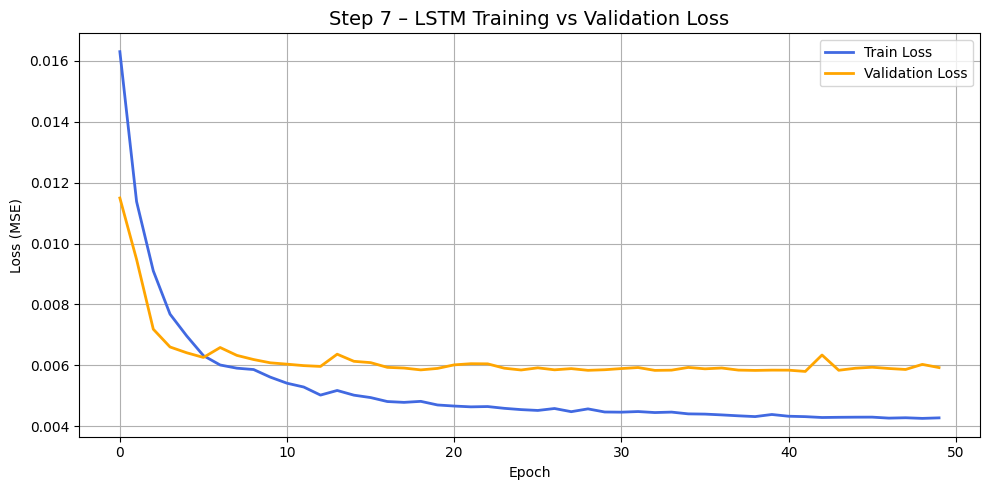

In [37]:
# Define asset folder path
assets_dir = '/content/drive/MyDrive/DSAI_SolarWeather_Forecasting/Assets'
os.makedirs(assets_dir, exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='royalblue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title("Step 7 – LSTM Training vs Validation Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and Show
plt.savefig(f"{assets_dir}/Step7_LSTM_Training_Loss.png", dpi=300)
plt.show()

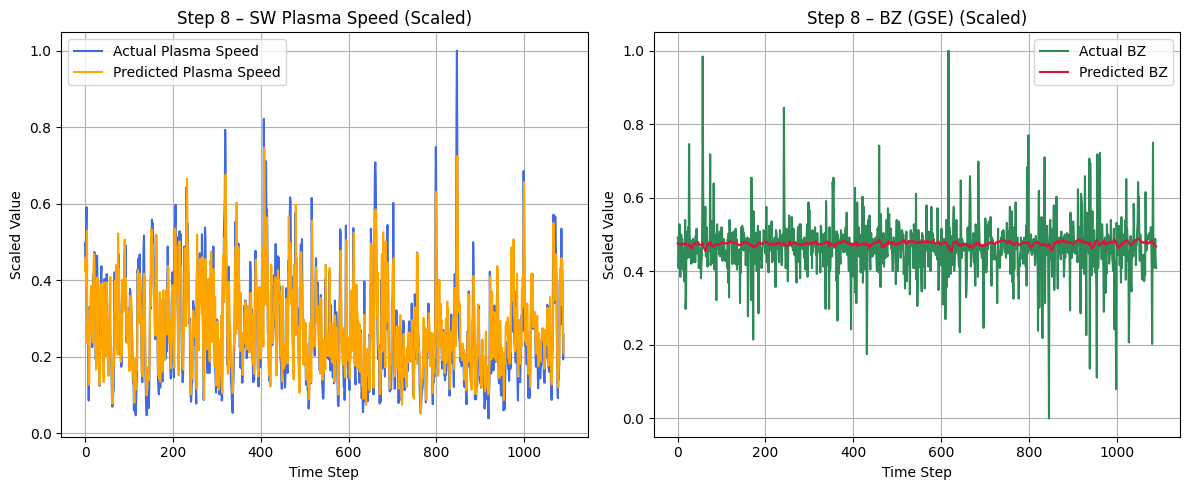

In [38]:
# Define asset folder path
assets_dir = '/content/drive/MyDrive/DSAI_SolarWeather_Forecasting/Assets'
os.makedirs(assets_dir, exist_ok=True)

plt.figure(figsize=(12, 5))

# Plasma Speed (Scaled)
plt.subplot(1, 2, 1)
plt.plot(y_test[:, 0], label='Actual Plasma Speed', color='royalblue')
plt.plot(y_pred[:, 0], label='Predicted Plasma Speed', color='orange')
plt.title("Step 8 – SW Plasma Speed (Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

# BZ (Scaled)
plt.subplot(1, 2, 2)
plt.plot(y_test[:, 1], label='Actual BZ', color='seagreen')
plt.plot(y_pred[:, 1], label='Predicted BZ', color='crimson')
plt.title("Step 8 – BZ (GSE) (Scaled)")
plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{assets_dir}/Step8_Predictions_Scaled.png", dpi=300)
plt.show()

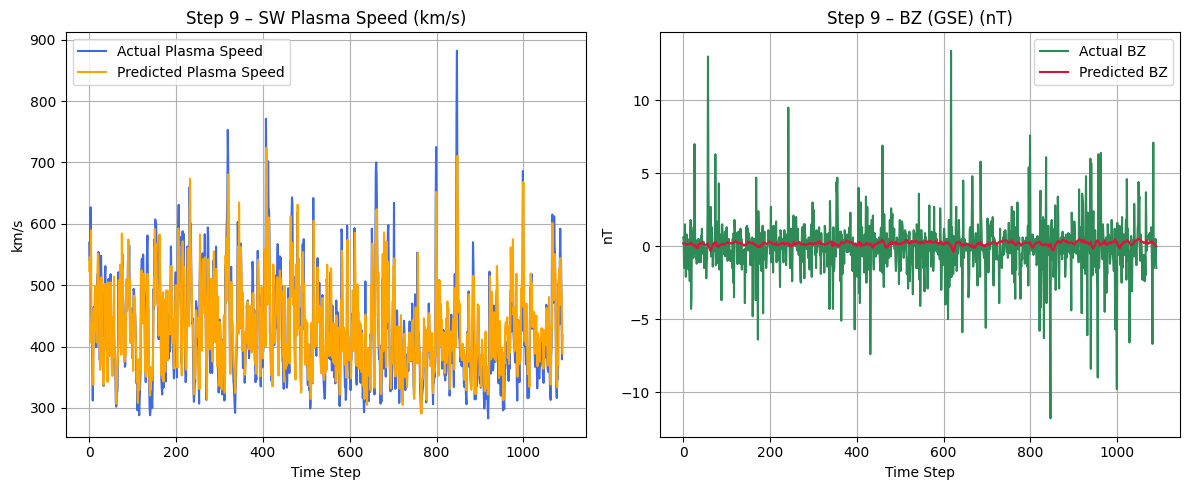

In [39]:
# Define asset folder path
assets_dir = '/content/drive/MyDrive/DSAI_SolarWeather_Forecasting/Assets'
os.makedirs(assets_dir, exist_ok=True)

plt.figure(figsize=(12, 5))

# Plasma Speed (km/s)
plt.subplot(1, 2, 1)
plt.plot(actual_plasma_speed, label='Actual Plasma Speed', color='royalblue')
plt.plot(pred_plasma_speed, label='Predicted Plasma Speed', color='orange')
plt.title("Step 9 – SW Plasma Speed (km/s)")
plt.xlabel("Time Step")
plt.ylabel("km/s")
plt.legend()
plt.grid(True)

# BZ (nT)
plt.subplot(1, 2, 2)
plt.plot(actual_bz, label='Actual BZ', color='seagreen')
plt.plot(pred_bz, label='Predicted BZ', color='crimson')
plt.title("Step 9 – BZ (GSE) (nT)")
plt.xlabel("Time Step")
plt.ylabel("nT")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{assets_dir}/Step9_Predictions_ActualUnits.png", dpi=300)
plt.show()

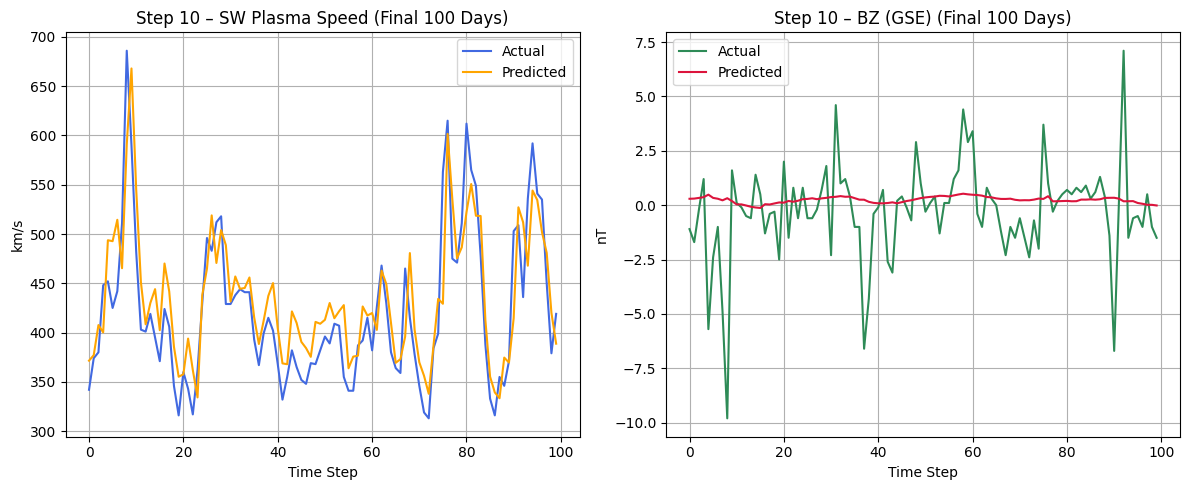

In [40]:
# Define asset folder path
assets_dir = '/content/drive/MyDrive/DSAI_SolarWeather_Forecasting/Assets'
os.makedirs(assets_dir, exist_ok=True)

zoom_range = -100

plt.figure(figsize=(12, 5))

# Plasma Speed Zoomed
plt.subplot(1, 2, 1)
plt.plot(actual_plasma_speed[zoom_range:], label='Actual', color='royalblue')
plt.plot(pred_plasma_speed[zoom_range:], label='Predicted', color='orange')
plt.title("Step 10 – SW Plasma Speed (Final 100 Days)")
plt.xlabel("Time Step")
plt.ylabel("km/s")
plt.legend()
plt.grid(True)

# BZ Zoomed
plt.subplot(1, 2, 2)
plt.plot(actual_bz[zoom_range:], label='Actual', color='seagreen')
plt.plot(pred_bz[zoom_range:], label='Predicted', color='crimson')
plt.title("Step 10 – BZ (GSE) (Final 100 Days)")
plt.xlabel("Time Step")
plt.ylabel("nT")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{assets_dir}/Step10_Zoomed_Final_100Days.png", dpi=300)
plt.show()

# Project Summary: Solar Flare & CME Forecasting Using LSTM

In this project, we explored solar weather prediction by leveraging NASA's OMNIWeb time-series data to forecast key indicators of solar activity, including Solar Wind Plasma Speed and Magnetic Field BZ (GSE). These variables are closely associated with the onset of Solar Flares and Coronal Mass Ejections (CMEs) — events that significantly impact Earth's magnetosphere and technology systems.

**We performed:**

Data pre-processing and feature engineering from daily-averaged space weather records

Exploratory data analysis (EDA) to understand feature behaviors

LSTM-based time series modeling using TensorFlow/Keras to learn temporal dependencies

Model evaluation, visualization, and storage of results for reproducibility

All key plots and the trained model are stored in the Assets/ directory.

This foundational framework opens doors for future enhancements, such as multi-variable forecasting, real-time deployment, and integration with satellite imagery for early-warning systems in space weather analytics.